In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from scipy.interpolate import UnivariateSpline
import sys
import os
from scipy import optimize
from scipy import constants
import scipy as scp
from scipy.signal import butter,filtfilt

import shelve as shv

import json
from pandas import Series
from pandas import Timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import stats 
import h5py
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from numba import jit, njit, prange
from scipy.signal import hilbert


SMALL_SIZE = 6
MEDIUM_SIZE = 7
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




cm = 1/2.54

eCharge= 1.602e-19

FE = np.genfromtxt('gapsweep/fe_50nm.txt', delimiter=',')
phase = np.genfromtxt('gapsweep/phase_50nm.txt', delimiter=',')
wavelength = np.genfromtxt('gapsweep/wavelength_in_um.txt', delimiter=',')

c= 2.99792458e8


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(-1e-13, 1e-13)

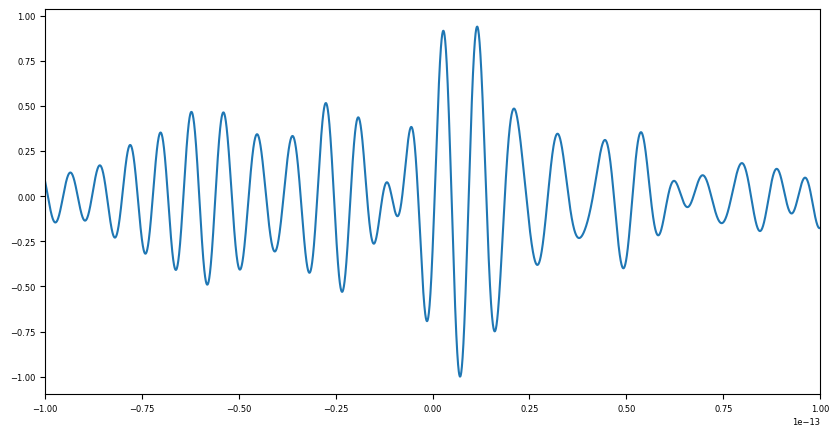

In [3]:

t = np.genfromtxt('TimeMIRMeasured04112022.csv',delimiter=',')
eField = hilbert(np.genfromtxt('efieldMIRMeasured04112022.csv',delimiter=','))
#timeAxis = np.genfromtxt('TimeMIR.csv',delimiter=',')
#eField = hilbert(np.genfromtxt('eFieldMIR.csv',delimiter=','))



eFieldNorm = np.exp(-1j*np.pi/2)*eField/np.max(np.abs(eField))

plt.plot(t,np.real(eFieldNorm))
plt.xlim([-0.1e-12,0.1e-12])


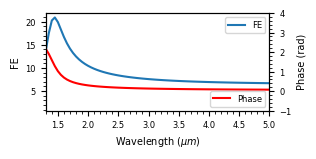

In [4]:

fig,ax = plt.subplots(1,1,figsize=(cm*8,cm*4))

ax.plot(wavelength  ,FE)
ax = plt.gca()
ax.set_ylabel('FE')
ax.minorticks_on()
ax.set_xlabel('Wavelength ($\mu m$)')
ax.set_xlim([1.3,5])
ax2 = ax.twinx()
ax2.plot(wavelength[1:],phase[1:],'r')
ax2.minorticks_on()
ax2.set_ylabel('Phase (rad)')
ax2.set_ylim([-1,4])
ax.legend(['FE'],loc='upper right')
ax2.legend(['Phase'],loc='lower right')
fig.tight_layout()
fig.savefig('FEandPhaseV2.pdf')
fig.savefig('FEandPhaseV2.png',dpi=300)


In [5]:
def transferFCN(t,Field,wavelength,FEin,phaseIn):
    #t is the time axis
    #Field is the field
    #FE is the field enhancement
    #phase is the phase
    #wavelength is the wavelength axis
    
    #convert to frequency domain
    freq = np.fft.fftfreq(len(t),t[1]-t[0])
    #FieldFreq = np.fft.fft(Field)
    fitFE = scp.interpolate.interp1d((c/(wavelength*1e-6)),FEin,fill_value=0,bounds_error=False)
    FEresampled = fitFE(np.abs(freq))
    phase = scp.interpolate.interp1d((c/(wavelength*1e-6)),phaseIn,fill_value=0,bounds_error=False)
    
    return FEresampled*np.exp(-1j*phase(np.abs(freq)))

(0.0, 300000000000000.0)

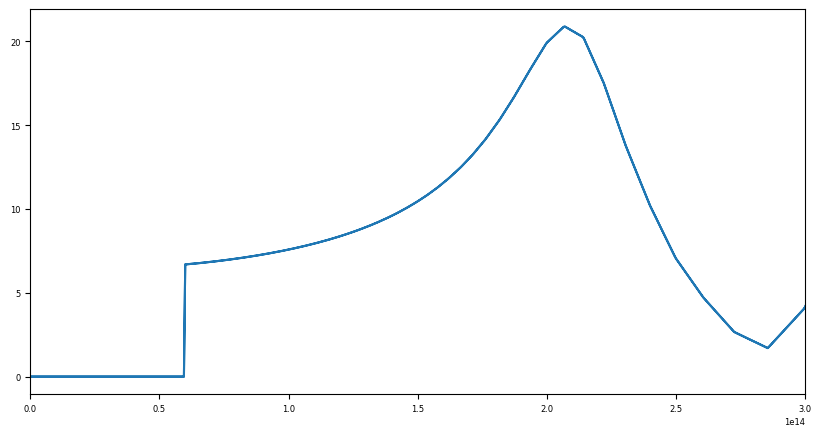

In [6]:
lfield = transferFCN(t,eFieldNorm,wavelength,FE,phase)

freq = np.fft.fftfreq(len(t),t[1]-t[0])


plt.plot(np.abs(freq),np.abs(lfield))
plt.xlim([0,0.3e15])


/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_98033/2464564244.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(c/freq,np.abs(np.fft.fft(eFieldNorm))*lfield/np.max(np.abs(np.fft.fft(eFieldNorm))*lfield))
/Users/felix/Coding/PaperPublicData/.conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/felix/Coding/PaperPublicData/.conda/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_98033/2464564244.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(c/freq,np.abs(np.fft.fft(eFieldNorm))/np.max(np.abs(np.fft.fft(eFieldNorm))))


(1e-06, 5e-06)

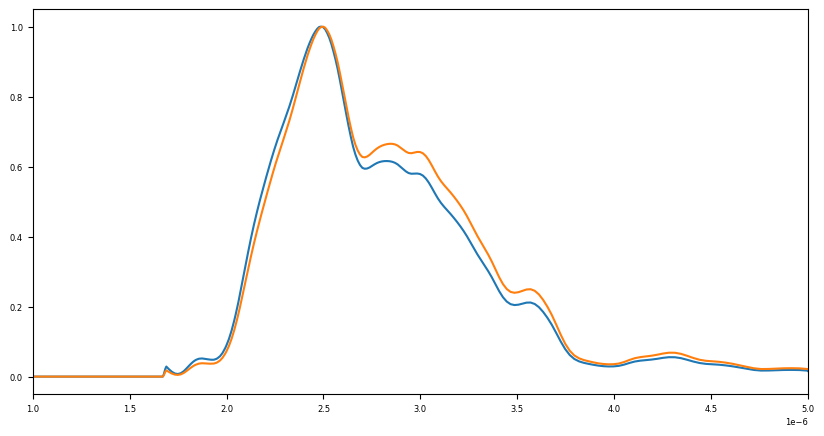

In [7]:
plt.plot(c/freq,np.abs(np.fft.fft(eFieldNorm))*lfield/np.max(np.abs(np.fft.fft(eFieldNorm))*lfield))
plt.plot(c/freq,np.abs(np.fft.fft(eFieldNorm))/np.max(np.abs(np.fft.fft(eFieldNorm))))

plt.xlim([1e-6,5e-6])




8.166961448292168


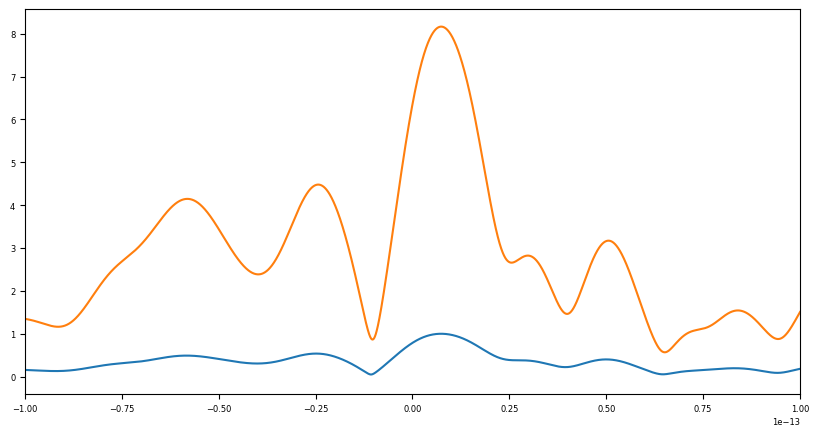

In [8]:
eLField = np.fft.ifft(np.fft.fft(eFieldNorm)*lfield)
field = eFieldNorm #eField/np.max(np.abs(eField))
plt.plot(t,np.abs(field))
plt.plot(t,np.abs(eLField)/np.max(np.abs(field)))
plt.xlim([-0.1e-12,0.1e-12])


np.savetxt('eLFieldPlasmon04112022.csv',np.real(eLField)/np.max(np.abs(eLField)),delimiter=',')
np.savetxt('eFieldPlasmonTime04112022.csv',(t),delimiter=',')


print(np.max(np.max(np.abs(eLField)))/np.max(np.abs(field)))

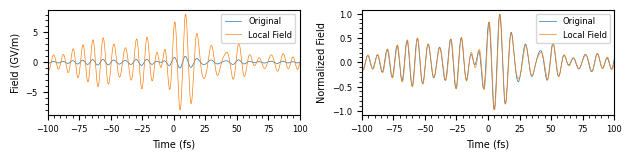

In [9]:

fig,[ax2,ax] = plt.subplots(1,2,figsize=(cm*16,cm*4),sharex=True)

ax.plot(t*1e15,np.real(np.exp(1j*(np.pi/2))*field)/np.max(np.abs(field)),linewidth=0.5)
ax.plot(t*1e15,np.real(np.exp(1j*(np.pi/2))*eLField)/np.max(np.abs(eLField)),linewidth=0.5)
ax.set_xlim([-100,100])
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Normalized Field')
ax.minorticks_on()
ax.legend(['Original','Local Field'])


ax2.plot(t*1e15,np.real(np.exp(1j*(np.pi/2))*field),linewidth=0.5)
ax2.plot(t*1e15,np.real(np.exp(1j*np.pi/2)*eLField),linewidth=0.5)
ax2.set_xlim([-100,100])
ax2.set_xlabel('Time (fs)')
ax2.set_ylabel('Field (GV/m)')
ax2.minorticks_on()
ax2.legend(['Original','Local Field'])

fig.tight_layout()

fig.savefig('LocalFieldComparison.pdf')

(-100.0, 100.0)

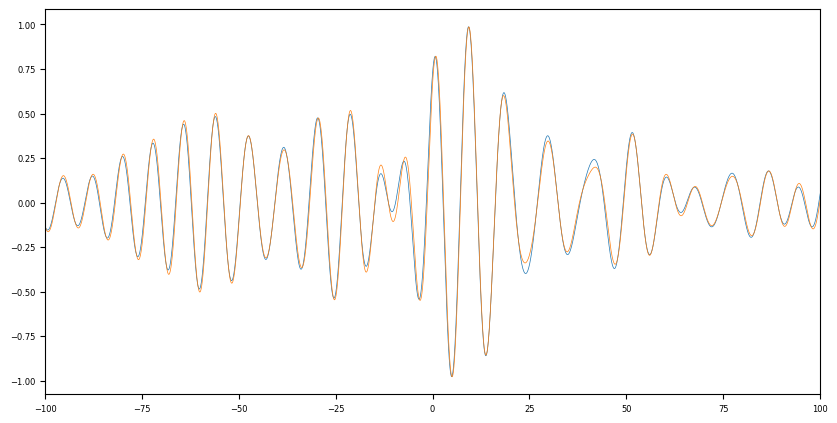

In [10]:

plt.plot(t*1e15,np.real(np.exp(1j*(np.pi/2))*field)/np.max(np.abs(field)),linewidth=0.5)
plt.plot(t*1e15,np.real(np.exp(1j*(np.pi/2 ))*eLField)/np.max(np.abs(eLField)),linewidth=0.5)
plt.xlim([-100,100])

In [11]:
spline = UnivariateSpline(t, (np.abs(eLField)**2)/np.max(np.abs(eLField)**2)-0.5,s=0,k=3)
r1 = spline.roots()
print('1. Pulse duration after all:',np.abs(r1[0]-r1[1]))

1. Pulse duration after all: 1.780868204166755e-14


In [12]:
from scipy.integrate import trapz

spectrumPhase = np.fft.fft(eLField)
freq = np.fft.fftfreq(len(t),t[1]-t[0])



wavelength = 1e9*c/(freq)
idx1 = np.abs(freq-c/5e-6).argmin()
idx2 = np.abs(freq-c/1e-6).argmin()

wavelength = wavelength[idx1:idx2]
wavelength = np.flip(wavelength)
psd = (np.abs(spectrumPhase)**2)[idx1:idx2]
psd = np.flip(psd)

ptot = trapz(psd,wavelength)

cwav = (1/ptot)*trapz(psd*wavelength,wavelength)

print(f" Center Wavelength: {cwav} nm")

print(f" Cycle Period: {cwav*1e-9/c} fs")

print(f"Cycles per Pusle:{np.abs(r1[0]-r1[1])/(cwav*1e-9/c)}")

 Center Wavelength: 2642.5674618746802 nm
 Cycle Period: 8.81465624420305e-15 fs
Cycles per Pusle:2.0203490128590564


/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_98033/1204989673.py:8: RuntimeWarning: divide by zero encountered in divide
  wavelength = 1e9*c/(freq)
